***
***

<img width="220" align="right" alt="Screen Shot 2020-10-14 at 20 48 36" src="https://user-images.githubusercontent.com/8030363/96350526-7d09a680-1073-11eb-9e45-a510c496bcc1.png">


# OMOP2OBO

### *Ontologizing Health Systems at Scale: Making Translational Discovery a Reality*

<br>

**Author:** [TJCallahan](https://mail.google.com/mail/u/0/?view=cm&fs=1&tf=1&to=callahantiff@gmail.com)  
**GitHub Repository:** [OMOP2OBO](https://github.com/callahantiff/OMOP2OBO/wiki) ([`V1.0`](https://github.com/callahantiff/OMOP2OBO/wiki/v1.0))  
**Analysis Dates:** `10/16/2020`

<br>

***
***

### Notebook Objective   
The purpose of this notebook is to present the results for the preliminary manuscript describing the `OMOP2OBO` algorithm and mappings. For this analysis, each clinical concepts from several domains (i.e. Conditions, Drug Ingredients, and Measurements) will separately analyzed with respect to the specific Open Biomedical Ontologies (OBO) it was mapped to. The analysis is presented in the order of the mapping algorithm workflow, which is shown below. Additional information on each of the steps shown in this figure, with respect to the analyses performed in this notebook, are provided below.

**This notebook presents results from validating the `OMOP2OBO` mappings.**

<img width="2000" alt="Screen Shot 2020-09-20 at 22 59 00" src="https://user-images.githubusercontent.com/8030363/96931469-99924e00-147a-11eb-9c19-fe5a95786772.png">


**Jupyter Notebooks:** [`omop2obo_manuscript_analyses.ipynb`](https://github.com/callahantiff/OMOP2OBO/tree/master/resources/analyses/omop2obo_manuscript_analyses.ipynb) 

- **Step 1: Concept Alignment:** This section describes the results generated from performing exact alignment between `OMOP` concept source codes and ontology concept database cross-references (i.e. dbXRefs) as well as `OMOP` concept labels and synonyms to ontology concept labels and synonyms. Done for `Concepts used in Practice` and `Standard Concepts not used in Practice` and for data at the concept- and ancestor-level. 


- **Step 2: Concept Embedding:** This section describes the results from creating embeddings using a Bag-of-Words + TF-IDF vector space model. This model was created using `OMOP` concept labels and synonyms and ontology concept labels and synonyms. To retrieve mappings from this model, a cosine similarity score was calculated between all clinical and ontology concepts. Only those mappings that were greater than a cut-off threshold (<u>></u>`0.25` for drug ingredients and medications and <u>></u>`0.20` for conditions) and within the top 75% of the distribution of scores were kept. This is performed for `Concepts used in Practice` and `Standard Concepts not used in Practice` and for data at the concept-level.


- **Step 3: Manual Annotation:** This section describes the results obtained from manual annotation. Performed only on `Concepts used in Practice` at the concept-level.


- **Step 4: Final Mapping:** The final set of mappings will be presented. This will include descriptions of mappings by mapping category as well as what level (i.e. concept, ancestor) mappings were created.

<br> 

**Jupyter Notebooks:** Current Notebook   

- **Validation:** This section describes results from three different types of validation designed to assess the accuracy, generalizability, and consistency of the final mapping set.


***
## Table of Contents <a class="anchor" id="toc"></a>
***

This notebook divides the analysis into two components: (1) summarization of mapping results and (2) validation of mapping results. 

### Mapping Validation   
  - [Domain Expert Review](#expert-review)  
  - [Coverage Study](#coverage-study)  
  - [Logical Validation](#logical-eval)  

***
***

<br>

## Set-up Environment
***

In [20]:
# import needed libraries
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
import urllib.request
import warnings

from collections import Counter
from datetime import date, datetime
from itertools import combinations
from more_itertools import unique_everseen
from scipy.stats import chi2, chi2_contingency

from analytic_utils import *

# set time-stamped var for writing output to
date_today = '_' + datetime.strftime(datetime.strptime(str(date.today()), '%Y-%m-%d'), '%d%b%Y').upper()


### Data 

There are several data files needed for this analysis. Each needed data source is described in the table below and can be accessed directly from the [Wiki](https://github.com/callahantiff/OMOP2OBO/wiki/V1.0).   

Data | Data Type | Description | File  
:--: | :--: | :-- | --  
Condition Concept Mappings | `Mapping Data` | An Excel workbook of Sheets storing different result sets:<br>(1) DbXRef_Mapping_Results;<br>(2) String_Mapping_Results;<br>(3) Similarity_Mapping_results;<br>(4) Aggregated_Mapping_Results | `Condition_Occurrence_Mapping_Full_Oct2020.xlsx`
Drug Ingredient Concept Mappings | `Mapping Data` | An Excel workbook of Sheets storing different result sets:<br>(1) DbXRef_Mapping_Results;<br>(2) String_Mapping_Results;<br>(3) Similarity_Mapping_results;<br>(4) Aggregated_Mapping_Results | `Drug_Exposure_Mapping_Full_Oct2020.xlsx`  
Measurement Concept Mappings | `Mapping Data` | An Excel workbook of Sheets storing different result sets:<br>(1) DbXRef_Mapping_Results;<br>(2) String_Mapping_Results;<br>(3) Similarity_Mapping_results;<br>(4) Aggregated_Mapping_Results | `Measurement_Mapping_Subset_Oct2020.xlsx`  
Clinical Concept Frequency | `Mapping Data` | A `csv` file containing metadata for the condition, drug_exposure, and measurement codes utilized in practice. The sheet includes data describing the number of visits and people that have utilized each concept as well as the total number of times the concept was used in practice | `OMOP2OBO_2020_COMOP2OBO_Coverage_Counts.csv`  
Expert Mapping Validation | `Validation Data` | An Excel Workbook containing a separate sheet for each mapping set that received expert review:<br>(1) Conditions_AprJul2019;<br>(2) Drugs_FebApr2019;<br>(3) Labs_JanMar2019;<br>(4) LabsSurvey_Oct2018Jan2019 | `OMOP2OBO_V1.0_Validation_Subset_Oct2020.xlsx`
Concept Prevalence Data | `Validation Data` | An Excel Workbook containing several sheets that store modified concept prevalence data: (1) Database_Summary;<br>(2) Database_Domain_Count;<br>(3) Condition_Occurence_Concepts;<br>(4) Drug_Exposure_Concepts;<br>(5) Measurement_Concepts | `ConceptPrevalenceTiffany_OHDSI_Sep2020_FULL.xlsx`   

<br>

*NOTE.* The `Clinical Concept Frequency` and all `Validation Data` contain some private institutional data and thus are not publicly available at this time. If you are interested in any of these data sources, please email Tiffany Callahan (`callahantiff@gmail.com`).

### Global Variables

In [ ]:
### GLOBAL URLS FOR DATA
### mapping data
conds_mapping_url = '<<>URL>>'
meds_mapping_url = '<<>URL>>'
labs_mapping_url = '<<>URL>>'

# concept frequencies
chco_concept_freq_url = '<<>URL>>'

### validation data
# accuracy
conds_validation = '<<>URL>>' 
meds_validation = '<<>URL>>' 
labs_validation = '<<>URL>>' 

# coverage
coverage_data = '<<>URL>>'
error_analysis_data = '<<>URL>>'


In [201]:
### GLOBAL VARIABLES AND SETTINGS
# create global variables to store ontologies by clinical domain
condition_onts = ['HP', 'MONDO']  
ingredient_onts = ['CHEBI', 'PR', 'NCBITAXON', 'VO']
measurement_onts = ['HP', 'CHEBI', 'CL', 'UBERON', 'PR', 'NCBITAXON']  

# silencing warnings
warnings.filterwarnings('ignore')

# set plotting arguments
%matplotlib inline
plt.style.use('ggplot')

# color palette
my_pal = {'HP': 'mediumpurple',
          'MONDO': 'cadetblue',
          'UBERON': 'gold',
          'VO': 'rebeccapurple',
          'PRO': 'darkorange',
          'NCBITaxon': 'mediumturquoise',
          'CL': 'hotpink',
          'CHEBI': 'limegreen'}


<br>

***
## Mapping Validation <a class="anchor" id="mapping-validation"></a>
***  

This section describes the work that was done in order to validate the mappings presented above. Several types of validation were needed in order to provide evidence of the usefulness of the `OMOP2OBO` mappings. To accomplish this goal, we designed three tasks to assess the accuracy, generalizability, and logical consistency of the mappings. Each of these tasks is described and presented below.

***

- [Domain Expert Review](#expert-review)  
- [Coverage Study](#coverage-study)  
- [Logical Validation](#logical-eval) 

***

## Domain Expert Review <a class="anchor" id="expert-review"></a>

***

**Wiki:** [`Accuracy Validation`](https://github.com/callahantiff/OMOP2OBO/wiki/Accuracy)  


The goal of this evaluation task was to assess the accuracy of the manually constructed mappings. To complete this work, domain experts with expertise spanning clinical care (i.e. adult and pediatric clinicians), clinical pharmacology, epidemiology, molecular biology, and biocuration were recruited and asked to help validated randomly selected subsets of the `OMOP2OBO` mappings.  

***  

**Clinical Domains**  
- [Conditions](#expert-conditions)  
- [Drug Ingredients](#expert-drugs)  
- [Measurements](#expert-labs) 

<br>


<br>

### Conditions <a class="anchor" id="expert-conditions"></a>

***

**Task Timeline:** `04/2019-06/2019`   
**Wiki:** [`OMOP2OBO_V1.0_Validation_Conditions.xlsx`](https://github.com/callahantiff/OMOP2OBO/wiki/Accuracy) 

<br>

**Details:**  
A practicing clinician was asked to review 1,000 `HPO` and 1,000 `DOID` manual and manual constructor mappings. When performing the review, the clinician was asked to assess the <u>clinical accuracy</u> of each mapping and if a mapping was determined to be incorrect, to work with a member of the team to find a more accurate mapping. Since the verification was performed, all `DOID` concepts were replaced by `MONDO`. Exact match alignments between these ontologies were utilized to ensure accurate translation between ontologies. This also provides confidence when extending the verification efforts to these terms. In addition to providing the exact mappings to `MONDO`, the spreadsheet (link above) also contains updated mappings (marked with `V1.0` in the header) to illustrate how the mappings have been updated as the algorithm evolves.

**Results:**  
*Iterations*  
- `DOID`: 0 (89.5%); 1 (6.5%); 2 (3.2%); 3(0.8%)  
- `HPO`: 0 (85.2%); 1 (10.3%); 2 (3.8%); 3(0.6%); 4 (0.1%)  

*Mapping Results*  
- `DOID`  
  - Correct: 65.5% (n=655)  
  - Incorrect: 23.7% (n=237)    
  - Discussed: 10.8% (75% correct)  
- `PO`  
  - Correct: 62.7% (n=627)  
  - Incorrect: 22.2% (n=222)    
  - Discussed: 15.1% (80.8% correct)  


In [22]:
# read in data
condition_accuracy = pd.read_excel(conds_validation, sep=',', header=0)
condition_accuracy.fillna('', inplace=True)

# view data
condition_accuracy.head(n=3)


,CONCEPT ID,CONCEPT LABEL,DOID (V.0),DOID LABEL (V.0),DOID MAPPING (V.0),MONDO (V.0),MONDO LABEL (V.0),MONDO MAPPING (V.0),MONDO LOGIC (V.1),MONDO (V.1),...,VERIFY ONTOLOGY,MAPPING ACTION,CLINICIAN RESPONSE,RESERACHER RESPONSE,MAPPING INCORRECT,ITERATION,Unnamed: 25,MAPPING AGREEMENT,DOID (V.0).1,HPO (V.0).1
0,132416,Cauliflower ear,DOID_379 | DOID_2213,AND | external ear disease | hemorrhagic disease,Manual Constructor,MONDO_0002776 | MONDO_0002243,external ear disease | hemorrhagic disease,Manual Constructor,AND,MONDO_0024505 | MONDO_0000001 | MONDO_0021199 ...,...,DOID,Incorrect,thoughts on changing 1222 to the hemorrhagic d...,Updated.,Yes,0,,Incorrect,237,222
1,132841,Malignant lymphoma of lymph nodes of multiple ...,DOID_8675,lymphosarcoma,Manual,MONDO_0004638,lymphosarcoma,Manual,,MONDO_0004638,...,DOID,Correct,,,No,0,,Discuss,108,151
2,133147,Primary malignant neoplasm of skin of trunk,DOID_0060118 | DOID_4159,AND | thoracic disease | skin cancer,Manual Constructor,MONDO_0000651 | MONDO_0002898,thoracic disease | skin cancer,Manual Constructor,AND,MONDO_0000651 | MONDO_0002898,...,DOID,Discuss,"Sample problem as row 645. Could work, but we'...","Yeah, this is a problem with their ontology. I...",No,1,,Correct,655,627


In [23]:
# get information on iterations
condition_accuracy.groupby(['VERIFY ONTOLOGY', 'ITERATION']).size().reset_index(name='COUNTS')


,VERIFY ONTOLOGY,ITERATION,COUNTS
0,DOID,0,895
1,DOID,1,65
2,DOID,2,32
3,DOID,3,8
4,HPO,0,852
5,HPO,1,103
6,HPO,2,38
7,HPO,3,6
8,HPO,4,1


In [24]:
# print the 
condition_accuracy.groupby(['VERIFY ONTOLOGY', 'MAPPING ACTION', 'MAPPING INCORRECT']).size().reset_index(name='COUNTS')


,VERIFY ONTOLOGY,MAPPING ACTION,MAPPING INCORRECT,COUNTS
0,DOID,Correct,No,655
1,DOID,Discuss,No,81
2,DOID,Discuss,Yes,27
3,DOID,Incorrect,Yes,237
4,HPO,Correct,No,627
5,HPO,Discuss,No,122
6,HPO,Discuss,Yes,29
7,HPO,Incorrect,Yes,222


<br>

### Drug Ingredients <a class="anchor" id="expert-drugs"></a>

***

**Task Timeline:** `01/2019-10/2019`   
**Wiki:** [`OMOP2OBO_V1.0_Validation_DrugIngredients.xlsx`](https://github.com/callahantiff/OMOP2OBO/wiki/Accuracy) 

<br>

**Details:**  
A practicing clinical pharmacist was asked to review 116 manual and manual constructor mappings. When performing the review, the clinical pharmacist was asked to assess the <u>clinical accuracy</u> of each mapping and if a mapping was determined to be incorrect, to work with a member of the team to find a more accurate mapping. Since the initial verification was performed significant improvements have been made to the mapping algorithm and the way that drug mappings are conceptualized. The results of this work have been applied to update the verification spreadsheet, but the initial results remain in tact.

**Results:**  
*Iterations:* 0 (57.8%); 1 (41.1%); 2 (0.8%)

*Mapping Results*  
- Correct: 56.9% (n=66)  
- Incorrect: 15.5% (n=18)  
- Discuss: 27.6% (50% correct)  


In [25]:
# read in data
drug_accuracy = pd.read_excel(meds_validation, sep=',', header=0)
drug_accuracy.fillna('', inplace=True)

# view data
drug_accuracy.head(n=3)


,OMOP_ID,OMOP_LABEL,CHEBI_URI,CHEBI_LABEL,CHEBI_MAPPING,NCBITAXON_URI,NCBITAXON_LABEL,NCBITAXON_MAPPING,VO_URI,VO_LABEL,...,MAPPING ACTION,EXPERT JUSTIFICATION,RESEARCHER RESPONSE,INCORRECT ANNOTATION,ITERATIONS,Unnamed: 19,MAPPING AGREEMENT,Unnamed: 21,Yes,No
0,919204,Amylases,CHEBI_78152,enzyme mimic,Manual,NONE,NONE,Unmapped,NONE,NONE,...,Correct,,,No,0,,Incorrect,18,18,0
1,1436169,Antithrombin III,CHEBI_64926 | CHEBI_50249,serine protease inhibitor | anticoagulant,Manual Constructor,NONE,NONE,Unmapped,NONE,NONE,...,Correct,,,No,0,,Discuss,32,16,16
2,19000729,Aprotinin,CHEBI_35222,Inhibitor,Manual,NONE,NONE,Unmapped,NONE,NONE,...,Incorrect,"bovine pancreatic trypsin inhibitor (BPTI), an...",Utilizing the MOA-based concepts listed in CHE...,Yes,1,,Correct,66,0,66


In [26]:
# get information on iterations
drug_accuracy.groupby('ITERATIONS').size().reset_index(name='COUNTS')


,ITERATIONS,COUNTS
0,0,67
1,1,48
2,2,1


In [27]:
drug_accuracy.groupby(['MAPPING ACTION', 'INCORRECT ANNOTATION']).size().reset_index(name='COUNTS')


,MAPPING ACTION,INCORRECT ANNOTATION,COUNTS
0,Correct,No,66
1,Discuss,No,16
2,Discuss,Yes,16
3,Incorrect,Yes,18


<br>

### Measurements <a class="anchor" id="expert-labs"></a>

***

**Task Timeline:**  
- Survey: `10/2018-01/2019`   
- LOINC2HPO Extension: `01/2019-03/2019`   

**Wiki:** [`OMOP2OBO_V1.0_Validation_Measurements.xlsx`](https://github.com/callahantiff/OMOP2OBO/wiki/Accuracy) 

<br>

**Details:**  
*Survey*  
A subset of pediatric-specific laboratory test result mappings (n=`270`) were independently validated by five domain experts (i.e. three pediatric clinicians, a PhD-level molecular biologist, and a Master’s-level epidemiologist). The study was approved by the Colorado Multiple Institutional Review Board (15-0445). To perform this validation, a Qualtrics survey was designed so that each question featured a laboratory test description and set of reasonable HPO concepts.


*LOINC2HPO Extension*  
A professional biocurator who is part of the [OBO Foundy]() was asked to verify a random subset of the mappings between `600` `OMOP` measurement concepts (`1,800` lab test results) and ontology terms from the `HPO`. When performing the review, the biocurator was asked to assess the <u>clinical accuracy</u> of each mapping and if a mapping was determined to be incorrect, to work with a member of the team to find a more accurate mapping. Since the initial verification was performed significant improvements have been made to the mapping algorithm and the way that lab test results are conceptualized. The results of this work have been applied to update the verification spreadsheet, but the initial results remain in tact. Additionally, since the verification was performed, all of the mappings have been extended to include the following additional ontologies: `UBERON`, `CHEBI`, `PRO`, `NCBItaxon` and `CL`.

<br>

**Results:**  
*Survey* 
- 58 concepts were re-verified through multiple iterations of discussion with a clinician  
- Expert Agreement  
  - Clinicians: 85.2% (n=230) 
  - Biologist - Epidemiologist: 79.3% (n=214) 
  - Clinician - Biologist OR Epidemiologist: 92.9% (n=251) 

*LOINC2HPO Extension*  
- Full set: 73%  
- Adjusted denominator (removing unannotated results): 97.3%


*SURVEY*

In [28]:
# read in data
lab_accuracy_survey = pd.read_excel(labs_validation, sheet_name='Survey', sep=',', header=0)
lab_accuracy_survey.fillna('', inplace=True)

# view data
lab_accuracy_survey.head(n=3)


,Composite ID,LOINC_ID,Result,LOINC Label,Clinician 1,Clinician 2,Clinician 3,Reverification,Biologist,Epidem,...,Timestamp,Unnamed: 20,Clin-Clin.1,Unnamed: 22,Biol-Epi.1,Unnamed: 24,Clin-Biol/Epi,Unnamed: 26,L2H-Final.1,Unnamed: 28
0,28606-2_Low,28606-2,Low,1-Methylhistidine/Creatinine [Ratio] in Urine,NONE,NONE,NONE,HP_0004337,HP_0004337,HP_0010904,...,,,230,0.851852,214,0.792593,251,0.92963,147,0.942308
1,28606-2_High,28606-2,High,1-Methylhistidine/Creatinine [Ratio] in Urine,NONE,NONE,NONE,HP_0004337,HP_0003355,HP_0000093,...,,,0,0,0,0,0,0,114,0.422222
2,1742-6_Low,1742-6,Low,Alanine aminotransferase serum/plasma,NONE,NONE,HP_0010916,HP_0003199,HP_0410042,HP_0410042,...,,,40,0.148148,56,0.207407,19,0.0703704,9,0.0576923


In [29]:
# print agreement between the three clinicians
lab_accuracy_survey.groupby('Clin-Clin').size().reset_index(name='COUNT')


,Clin-Clin,COUNT
0,0,40
1,1,230


In [30]:
# print agreement between the biologist and epidemiologist
lab_accuracy_survey.groupby('Biol-Epi').size().reset_index(name='COUNT')


,Biol-Epi,COUNT
0,0,56
1,1,214


In [31]:
# print agreement between the 
lab_accuracy_survey.groupby('Clin-Biol|Epi').size().reset_index(name='COUNT')


,Clin-Biol|Epi,COUNT
0,0,19
1,1,251


In [32]:
# get counts of clinician re-verified concepts
iterations = [x for x in lab_accuracy_survey['Reverification'] if x != '----']

print('A total of {} were re-verified with the help of a clinician'.format(len(iterations)))


A total of 58 were re-verified with the help of a clinician


*LOINC2HPO EXTENSION*

In [33]:
# read in data
lab_accuracy_ext = pd.read_excel(labs_validation, sheet_name='LOINC2HPO Extension', sep=',', header=0)
lab_accuracy_ext.fillna('', inplace=True)

# view data
lab_accuracy_ext.head(n=3)


,LOINC_ID,Result,Composite_IDS,LOINC Label,LOINC2HPO_URI,LOINC2HPO_Label,NEG,Notes,TC_ID,TC_Label,NEG.1,Notes.1,Agreement,Final Notes,Unnamed: 14,MAPPING AGREEMENT,Unnamed: 16,Unnamed: 17
0,10368-9,Normal,10368-9_Normal,Lead [Mass/volume] in Capillary blood,HP_0410172,blood xenobiotic,True,,HP_0410399,positive blood lead test,True,https://github.com/obophenotype/human-phenotyp...,0,,,TOTAL REVIEWED LAB TESTS,600,
1,10368-9,Low,10368-9_Low,Lead [Mass/volume] in Capillary blood,,,,,HP_0410399,positive blood lead test,False,https://github.com/obophenotype/human-phenotyp...,0,,,TOTAL REVIEWED LAB TEST RESULTS,1800,
2,10368-9,High,10368-9_High,Lead [Mass/volume] in Capillary blood,HP_0410399,positive blood lead test,False,new term request?,HP_0410399,positive blood lead test,False,https://github.com/obophenotype/human-phenotyp...,1,,,AGREEMENT,1314,0.73


In [34]:
# get agreement adjusted for the removal of missing LOINC2HPO annotations
numerator = len([x for x in lab_accuracy_ext['Agreement'] if x == 1])
denominator = len(lab_accuracy_ext['Agreement'])

print('Results: {}% agreement ({} agree; {} disagree)'.format(round(numerator/denominator, 3)*100,
                                                              numerator,
                                                              denominator))


Results: 73.0% agreement (1314 agree; 1800 disagree)


In [35]:
# get agreement adjusted for the removal of missing LOINC2HPO annotations
numerator = len([x for x in lab_accuracy_ext['Agreement'] if x == 1])
adjst_denominator = denominator - len([x for x in lab_accuracy_ext['LOINC2HPO_URI'] if len(x) < 1])

print('Adjusted Results: {}% agreement ({} agree; {} disagree)'.format(round(numerator/adjst_denominator, 3)*100,
                                                                       numerator,
                                                                       adjst_denominator))
      

Adjusted Results: 97.3% agreement (1314 agree; 1350 disagree)


***

**Click [here](#mapping-validation) to return to the Mapping Validation section**  

***

<br>

## Coverage Study <a class="anchor" id="coverage-study"></a>

**Wiki:** [`Generalizability Validation`](https://github.com/callahantiff/OMOP2OBO/wiki/Generalizability)  

***

- [Conditions](#coverage-conditions)  
- [Drug Ingredients](#coverage-drugs)  
- [Measurements](#coverage-labs) 

***

This study aims to evaluate and characterize the generalizability or coverage of the OMOP vocabulary terms included in the `OMOP2OBO` mapping set to OMOP vocabulary terms utilized in the Observational Health Data Sciences and Informatics (OHDSI) [`Concept Prevalence`](https://forums.ohdsi.org/t/network-study-concept-prevalence/6562) study sites.

As described [here](https://forums.ohdsi.org/t/network-study-concept-prevalence/6562), the `Concept Prevalence` study was designed to provide researchers with additional context regarding the frequency at which different clinical codes occur across the OHDSI research network:

> We want to study the usage patterns of Concepts across different OMOP CDM instances. This in itself could be useful information to answer many questions, but we have a concrete reason: For any one medical entity, the granularity of codes captured in a data source can vary greatly. For example, Chronic Kidney Disorder stage II can be coded as ICD9 code 585.2 Chronic kidney disease, Stage II (mild); 585.9 Chronic kidney disease, unspecified or even as 586 Renal failure, unspecified. However, this information is key for any cohort definition. Currently, researchers have no way of knowing whether a certain concept with high granularity is even available for selection, or whether they have to use a generic concept in combination with some auxiliary information to define the cohort correctly. Each data source instance is a black box and knowledge about the distribution of the concepts is limited to the very instance researchers have access to. But OHDSI Network Studies are dependent on cohort definitions that work across the network.

Using these data, the main research question we aimed is how does the coverage of the OMOP vocabulary terms present in the `OMOP2OBO` mappings differ across the OHDSI `Concept Prevalence` study sites?

The specific aims of this study are as follows:

- Examine OMOP2OBO coverage across the Concept Prevalence sites by identifying:
  - OMOP vocabulary terms that exist in `OMOP2OBO` and one or more `Concept Prevalence` site
  - OMOP vocabulary terms only present in `OMOP2OBO` and none of the `Concept Prevalence` sites
  - OMOP vocabulary terms only present in one or more `Concept Prevalence` site
- Demonstrate the potential for [molecular] biological inference of `OMOP2OBO` by characterizing differences in OBO ontology term enrichment across the `Concept Prevalence` sites when varying different aspects of data provenance (e.g. site type, clinical specialty, and site location)


#### Conditions <a class="anchor" id="coverage-conditions"></a>  

***

The OHDSI `Concept Prevalence` data contained `62,335` unique OMOP vocabulary concepts from `24` sites. The `OMOP2OBO` vocabulary concepts from each of these sites was compared to the list of concepts from the `OMOP2OBO` mappings. After filtering the `OMOP2OBO` mappings to remove all entries where all ontologies were "NONE" or "NOT YET MAPPED" and all non-standard concepts, `92,367` concepts remained eligible for use in the coverage study. This means that all purposefully unmapped concepts (i.e. findings, injuries, complications, and carrier status) were kept within the data set as long as at least one of the other mapped ontologies was not an unmapped concept of type `NOT YET MAPPED` (i.e. was not an unmapped `Standard SNOMED-CT Concept Not Used In Practice`). 


**Experiments**  
- [Full Set Coverage](#full-set-coverage)  
- [Data Type Coverage](#data-type-coverage)  
- [Ontology Coverage](#ontology-coverage)  

<br>

**Results**  
The OHDSI `Concept Prevalence` data contained data for `24` sites. The `OMOP2OBO` vocabulary concepts from each of these sites was compared to the list of concepts from the `OMOP2OBO` mappings 


*Concept Overlap*


**Load Data**

*CHCO Concept Frequency Data*  


In [36]:
# read in frequency counts data
chco_concept_counts = pd.read_csv(chco_concept_freq_url, sep=',', header=0)
chco_concept_counts.fillna('', inplace=True)

# reduce columns
chco_concept_counts = chco_concept_counts[['CONCEPT_ID', 'DOMAIN', 'CONCEPT_COUNT', 'CONCEPT_COUNT_ADJUSTED']]

# subset data to only keep conditions
chco_concept_counts = chco_concept_counts[chco_concept_counts['DOMAIN'] == 'Conditions']

# view data
chco_concept_counts.head(n=5)


,CONCEPT_ID,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
0,760841,Conditions,1,100
1,4122179,Conditions,1,100
2,4254374,Conditions,1,100
3,4341363,Conditions,1,100
4,436140,Conditions,1,100


*OHDSI Concept Prevalence Data*


In [37]:
# load concept prevalence data
concept_prev_conds = pd.read_excel(coverage_data, sheet_name='Condition_Occurrence_Concepts', sep=',', header=0)
concept_prev_conds.fillna('', inplace=True)

# get only SNOMED concepts
concept_prev_conds = concept_prev_conds[concept_prev_conds['VOCAB (TJC)'] =='SNOMED']

# approved databases
concept_prev_conds = concept_prev_conds[concept_prev_conds['ANALYSIS APPROVED  (TJC)'] == 1]

# view data
concept_prev_conds.head(n=5)


,CONCEPT_ID,CONCEPT_NAME,DOMAIN (TJC),STANDARD (TJC),VOCAB (TJC),DATABASE_NAME,RECORD_COUNT,ANALYSIS APPROVED (TJC)
0,22274,Neoplasm of uncertain behavior of larynx,Condition,Standard,SNOMED,Ajou_university,100,1
1,22288,Hereditary elliptocytosis,Condition,Standard,SNOMED,Ajou_university,100,1
2,22340,Esophageal varices without bleeding,Condition,Standard,SNOMED,Ajou_university,1720,1
3,22350,Edema of larynx,Condition,Standard,SNOMED,Ajou_university,1817,1
4,22426,Congenital macrostomia,Condition,Standard,SNOMED,Ajou_university,100,1


*OMOP2OBO Condition Concept Mappings*


In [46]:
# load data
cond_mappings = pd.read_excel(conds_mapping_url, sheet_name='Aggregated_Mapping_Results', sep=',', header=0)
cond_mappings.fillna('', inplace=True)

# merge concept counts
cond_mappings = cond_mappings.merge(chco_concept_counts, how='left', on='CONCEPT_ID').drop_duplicates()

# get only standard concepts that have been mapped to at least 1 ontology
not_standard = cond_mappings.query('STANDARD != "S"')
not_mapped = cond_mappings.query('HP_URI == "NOT YET MAPPED" & MONDO_URI == "NOT YET MAPPED"')
nones = cond_mappings.query('HP_URI == "NONE" & MONDO_URI == "NONE"')
mixed_hp_nots = cond_mappings.query('HP_URI == "NOT YET MAPPED" & MONDO_MAPPING == "Unmapped"')
mixed_mondo_nots = cond_mappings.query('MONDO_URI == "NOT YET MAPPED" & HP_MAPPING == "Unmapped"')

cond_mappings_standard = cond_mappings[~cond_mappings.CONCEPT_ID.isin(not_standard['CONCEPT_ID']) &
                                       ~cond_mappings.CONCEPT_ID.isin(not_mapped['CONCEPT_ID']) &
                                       ~cond_mappings.CONCEPT_ID.isin(nones['CONCEPT_ID']) & 
                                       ~cond_mappings.CONCEPT_ID.isin(mixed_hp_nots['CONCEPT_ID']) & 
                                       ~cond_mappings.CONCEPT_ID.isin(mixed_mondo_nots['CONCEPT_ID'])]

# keep only needed columns
cond_mappings_standard.head()


,CONCEPT_ID,CONCEPT_LABEL,CONCEPT_TYPE,STANDARD,CUI,SEMANTIC_TYPE,HP_LOGIC,HP_URI,HP_LABEL,HP_MAPPING,HP_EVIDENCE,MONDO_LOGIC,MONDO_URI,MONDO_LABEL,MONDO_MAPPING,MONDO_EVIDENCE,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
0,76745,Capsular breast contracture of breast implant,Standard Concept Not Used In Practice,S,C0405492,Acquired Abnormality,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,NaN,NaN,NaN
1,374835,Anoxic brain damage during AND/OR resulting fr...,Standard Concept Not Used In Practice,S,C0274377,Disease or Syndrome,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,NaN,NaN,NaN
2,442086,Post-laminectomy lordosis,Standard Concept Not Used In Practice,S,C0158500,Acquired Abnormality,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,NaN,NaN,NaN
3,442549,Retracted nipple associated with childbirth,Standard Concept Not Used In Practice,S,C0157630,Acquired Abnormality,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,NaN,NaN,NaN
4,444241,Orbital deformity due to surgery,Standard Concept Not Used In Practice,S,C0271338,Acquired Abnormality,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,NaN,NaN,NaN


*Error Analysis Data*

ADD DESCRIPTION OF DATA HERE

In [443]:
# load data
error_analysis = pd.read_csv(error_analysis_data, sep=',', header=0)
error_analysis.fillna('', inplace=True)

# view data
error_analysis.head()

,relationship_id,SOURCE_CONCEPT_ID,SOURCE_CONCEPT_LABEL,TARGET_CONCEPT_ID,TARGET_CONCEPT_LABEL
0,Concept poss_eq from,134116,Dermatitis due to drug AND/OR medicine taken i...,4150178,Ingestion dermatitis due to drugs
1,Concept poss_eq from,42538028,CYP2C9 poor metabolizer,4310732,Disorder due cytochrome p450 CYP2C9 variant
2,Concept poss_eq from,443392,Malignant neoplastic disease,44801366,"[X]Malignant neoplasm of ill-defined, secondar..."
3,Concept poss_eq from,4108900,Embryonic cyst of ovary,4108899,Developmental ovarian cyst
4,Concept poss_eq from,42539465,Normal cellular hormonal pattern,4178575,Normal cellular hormonal pattern


<br>

#### Full Set Coverage<a class="anchor" id="cond-full-set-coverage"></a>    
This phase of the experiment aimed to demonstrate the coverage of the `OMOP2OBO` concepts 

In [47]:
print('There are {} `OMOP` concept ids covered by `HPO` or `MONDO` mappings via `OMOP2OBO` mappings'.format(len(cond_mappings_standard)))


There are 92367 `OMOP` concept ids covered by `HPO` or `MONDO` mappings via `OMOP2OBO` mappings


In [383]:
# get overall coverage metrics
cp_cond_concepts = set(list(concept_prev_conds['CONCEPT_ID']))
omop2obo_cond_concepts = set(list(cond_mappings_standard['CONCEPT_ID']))

# get general coverage across all Concept Prevalance databases
overlap_cond_concepts = cp_cond_concepts.intersection(omop2obo_cond_concepts)
only_omop2obo_cond_concepts = omop2obo_cond_concepts.difference(cp_cond_concepts)
only_cp_cond_concepts = cp_cond_concepts.difference(omop2obo_cond_concepts)

# print metrics
cond_coverage = 'The OMOP2OBO mappings covered {}% of the {} Concept Prevalance concepts'.format(round(len(overlap_cond_concepts)/(len(overlap_cond_concepts) + len(only_cp_cond_concepts))*100, 3),
                                                                                                   len(cp_cond_concepts))
omop2obo_only = '\n - {} concepts in OMOP2OBO that are not in the Concept Prevalance concept set'.format(len(only_omop2obo_cond_concepts))
cp_only = '\n - {} concepts in the Concept Prevalance concept set that are not in OMOP2OBO'.format(len(only_cp_cond_concepts))

print(cond_coverage, omop2obo_only, cp_only)


The OMOP2OBO mappings covered 92.505% of the 62335 Concept Prevalance concepts 
 - 34704 concepts in OMOP2OBO that are not in the Concept Prevalance concept set 
 - 4672 concepts in the Concept Prevalance concept set that are not in OMOP2OBO


#### ***Concept Counts by Coverage Set***

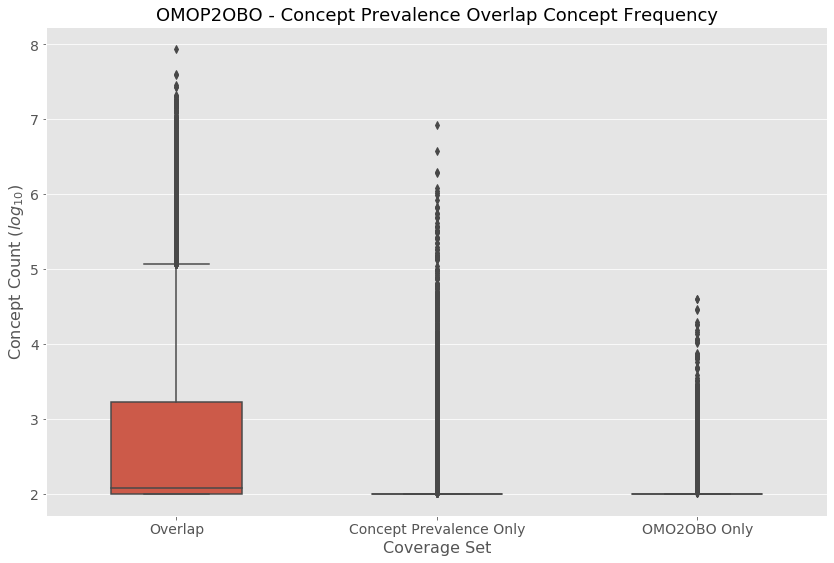

In [384]:
# process coverage set data
cond_coverage_sets = output_coverage_set_counts(concept_prev_conds, cond_mappings_standard,
                                                [overlap_cond_concepts, only_cp_cond_concepts, only_omop2obo_cond_concepts])

# create plot data
plt_data = pd.DataFrame({'set':['Overlap'] * len(cond_coverage_sets['overlap']['counts']) + ['Concept Prevalence Only'] * len(cond_coverage_sets['cp_only']['counts']) + ['OMO2OBO Only'] * len(cond_coverage_sets['omop2obo_only']['counts']),
                        'counts': cond_coverage_sets['overlap']['counts'] + cond_coverage_sets['cp_only']['counts'] + cond_coverage_sets['omop2obo_only']['counts']})

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='counts', x='set', data=plt_data, width=0.5)   
plt.title('OMOP2OBO - Concept Prevalence Overlap Concept Frequency', fontsize=18)
plt.suptitle("")
# plt.ylim(0,7)
plt.xlabel('Coverage Set', fontsize=16)
plt.ylabel('Concept Count ($log_{10}$)', fontsize=16)
plt.tick_params(labelsize=14)
plt.show()


OVERLAPPING CONCEPTS

In [385]:
# get stats on concepts in both sets and by ontology
covered_concepts_omop2obo = cond_mappings_standard[cond_mappings_standard.CONCEPT_ID.isin(list(overlap_cond_concepts))]

# split results by concept type (i.e. concepts used in practice, standard concepts)
cond_overlap_res = covered_concepts_omop2obo.groupby('CONCEPT_TYPE')

# re-group by ontology
cond_overlap_prac = cond_overlap_res.get_group('Concept Used In Practice').drop_duplicates()
cond_overlap_stnd = cond_overlap_res.get_group('Standard Concept Not Used In Practice').drop_duplicates()

# print the number of overlapping concepts
print('{} OMOP concepts overlapped in OMOP2OBO and the Concept Prevalence data'.format(len(overlap_cond_concepts)))


57663 OMOP concepts overlapped in OMOP2OBO and the Concept Prevalence data


*Concepts Used In Practice*

In [386]:
print('{} overlapping codes for Concepts Used in Practice'.format(len(cond_overlap_prac)))

# print mapping categories
cond_prac_hp_cat = cond_overlap_prac.groupby('HP_MAPPING').size().reset_index(name='COUNT')
cond_prac_mondo_cat = cond_overlap_prac.groupby('MONDO_MAPPING').size().reset_index(name='COUNT')

# create plotting data
prac_data = pd.DataFrame({'ontology': ['HP'] * len(cond_prac_hp_cat) + ['MONDO'] * len(cond_prac_mondo_cat),
                        'mapping_category': list(cond_prac_hp_cat['HP_MAPPING']) + list(cond_prac_mondo_cat['MONDO_MAPPING']),
                        'counts': list(np.log10(cond_prac_hp_cat['COUNT'])) + list(np.log10(cond_prac_mondo_cat['COUNT']))})


26807 overlapping codes for Concepts Used in Practice


In [387]:
# print hp data
cond_prac_hp_cat

,HP_MAPPING,COUNT
0,Automatic Constructor - Ancestor,1095
1,Automatic Constructor - Concept,123
2,Automatic Exact - Ancestor,2843
3,Automatic Exact - Concept,3506
4,Manual,4801
5,Manual Constructor,9217
6,Manual Exact - Concept Similarity,955
7,Unmapped,4267


In [388]:
# print mondo
cond_prac_mondo_cat


,MONDO_MAPPING,COUNT
0,Automatic Constructor - Ancestor,4133
1,Automatic Constructor - Concept,621
2,Automatic Exact - Ancestor,5411
3,Automatic Exact - Concept,4694
4,Manual,509
5,Manual Constructor,2523
6,Manual Exact - Concept Similarity,512
7,Unmapped,8404


*Standard SNOMED-CT Concepts Not Used In Practice*

In [389]:
print('{} overlapping codes for Standard SNOMED-CT Concepts Not Used in Practice'.format(len(cond_overlap_stnd)))

# print mapping categories
cond_stnd_hp_cat = cond_overlap_stnd.groupby('HP_MAPPING').size().reset_index(name='COUNT')
cond_stnd_mondo_cat = cond_overlap_stnd.groupby('MONDO_MAPPING').size().reset_index(name='COUNT')

# create plotting data
stnd_data = pd.DataFrame({'ontology': ['HP'] * (len(cond_stnd_hp_cat) + 2) + ['MONDO'] * (len(cond_stnd_mondo_cat) + 2),
                          'mapping_category': list(list(cond_stnd_hp_cat['HP_MAPPING']) + ['Manual Constructor', 'Manual']) + list(list(cond_stnd_mondo_cat['MONDO_MAPPING']) + ['Manual Constructor', 'Manual']),
                          'counts': list(np.log10(cond_stnd_hp_cat['COUNT'])) + [0, 0] + list(np.log10(cond_stnd_mondo_cat['COUNT'])) + [0, 0]})



30856 overlapping codes for Standard SNOMED-CT Concepts Not Used in Practice


In [390]:
# print hp data
cond_stnd_hp_cat

,HP_MAPPING,COUNT
0,Automatic Constructor - Ancestor,20539
1,Automatic Constructor - Concept,19
2,Automatic Exact - Ancestor,3873
3,Automatic Exact - Concept,878
4,Manual Exact - Concept Similarity,202
5,Unmapped,5345


In [391]:
# print mondo
cond_stnd_mondo_cat

,MONDO_MAPPING,COUNT
0,Automatic Constructor - Ancestor,19600
1,Automatic Constructor - Concept,197
2,Automatic Exact - Ancestor,449
3,Automatic Exact - Concept,2619
4,Manual Exact - Concept Similarity,94
5,Unmapped,7897


*Plot Counts of Concepts By Mapping Category*

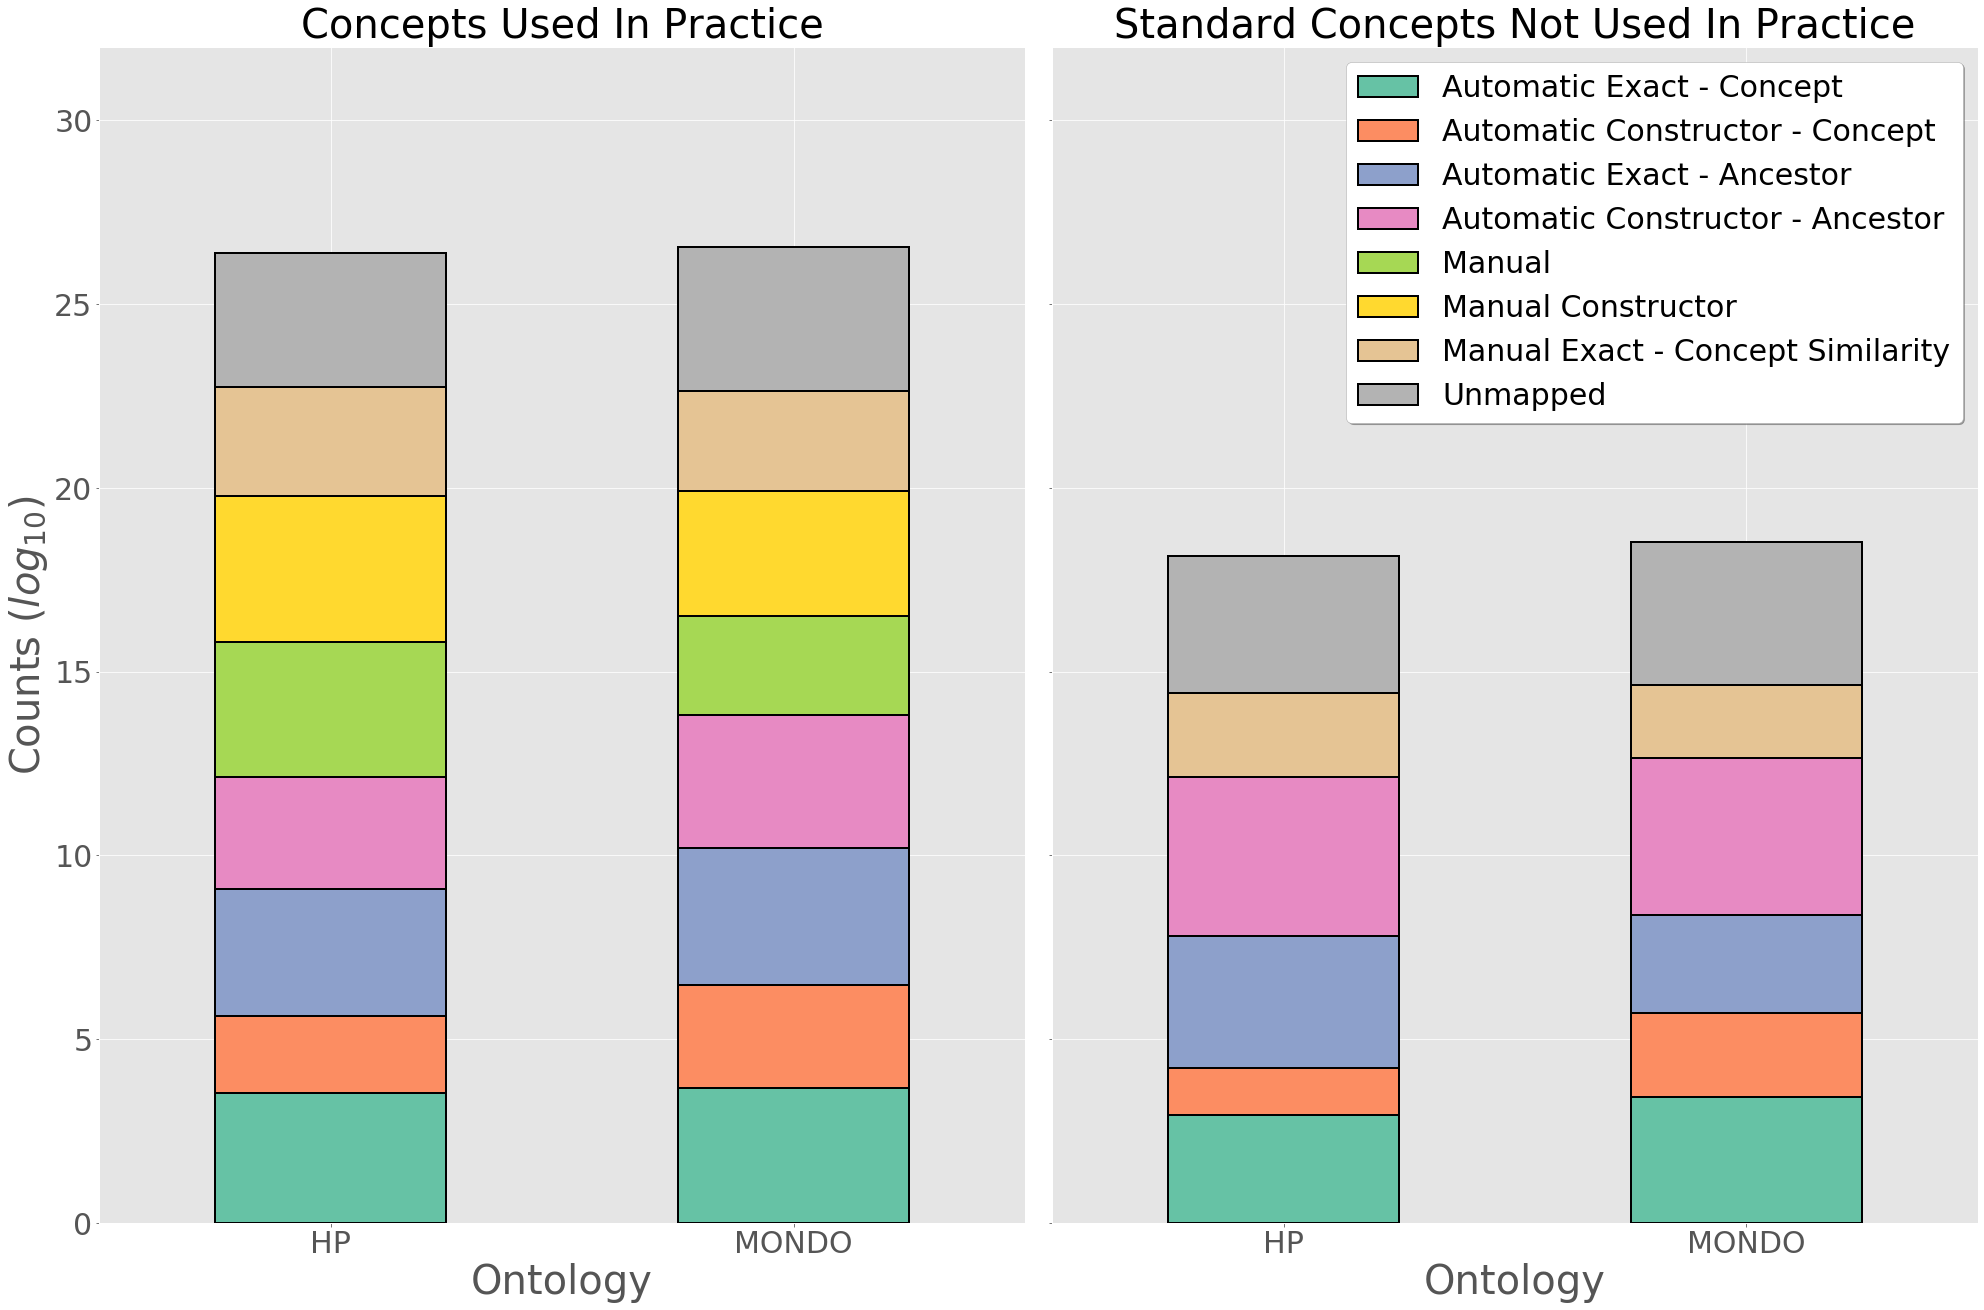

In [392]:
# create plot data
plots = { 'Concepts Used In Practice': prac_data, 'Standard Concepts Not Used In Practice': stnd_data}

ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Concept',
           'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
            'Manual', 'Manual Constructor', 'Manual Exact - Concept Similarity', 'Unmapped']

# create plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 18))

for df, ax in zip(plots.keys(), axes):
    plt_data = plots[df].pivot(index='ontology', columns='mapping_category', values='counts')
    plt_data = plt_data.reindex(ordering, axis=1)
    ax = plt_data.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', linewidth=2, colormap='Set2')
    ax.set_title(df, fontsize=40, alpha=1.0)
    ax.set_ylabel('Counts ($log_{10}$)', fontsize=40),
    ax.set_xlabel('Ontology', fontsize=40),
    ax.set_ylim(0, 32)
    ax.set_yticks(range(0, 32, 5))
    ax.set_yticklabels(labels=range(0, 32, 5), rotation=0, minor=False, fontsize=30)
    ax.set_xticklabels(labels=list(plt_data.index), rotation=0, minor=False, fontsize=30)
    handles, labels = ax.get_legend_handles_labels()

# look "one plot"
plt.tight_layout(pad=0.0, w_pad=-6.5, h_pad=0.0)
axes[1].set_ylabel("")
axes[1].set_yticklabels("")
axes[0].legend().set_visible(False)
axes[1].legend(ordering, fontsize=30, shadow=True, facecolor='white', edgecolor='darkgray', ncol=1)


OMOP2OBO ONLY

In [402]:
# get stats on concepts in both sets and by ontology
omop2obo_only_concepts = cond_mappings_standard[cond_mappings_standard.CONCEPT_ID.isin(list(only_omop2obo_cond_concepts))]

# split results by concept type (i.e. concepts used in practice, standard concepts)
cond_omop2obo_res = omop2obo_only_concepts.groupby('CONCEPT_TYPE')

# re-group by ontology
cond_omop2obo_prac = cond_omop2obo_res.get_group('Concept Used In Practice').drop_duplicates()
cond_omop2obo_stnd = cond_omop2obo_res.get_group('Standard Concept Not Used In Practice').drop_duplicates()

# print the number of overlapping concepts
print('{} OMOP concepts Only Found in OMOP2OBO'.format(len(omop2obo_only_concepts)))


34704 OMOP concepts Only Found in OMOP2OBO


*Concepts Used In Practice*

In [403]:
# print stats for hp category mapping
print('{} OMOP2OBO only codes for Concepts Used in Practice'.format(len(cond_omop2obo_prac)))

# print mapping categories
cond_prac_hp_cat = cond_omop2obo_prac.groupby('HP_MAPPING').size().reset_index(name='COUNT')
cond_prac_mondo_cat = cond_omop2obo_prac.groupby('MONDO_MAPPING').size().reset_index(name='COUNT')

# create plotting data
prac_data = pd.DataFrame({'ontology': ['HP'] * len(cond_prac_hp_cat) + ['MONDO'] * len(cond_prac_mondo_cat),
                        'mapping_category': list(cond_prac_hp_cat['HP_MAPPING']) + list(cond_prac_mondo_cat['MONDO_MAPPING']),
                        'counts': list(np.log10(cond_prac_hp_cat['COUNT'])) + list(np.log10(cond_prac_mondo_cat['COUNT']))})

2272 OMOP2OBO only codes for Concepts Used in Practice


In [404]:
# print hp data
cond_prac_hp_cat

,HP_MAPPING,COUNT
0,Automatic Constructor - Ancestor,43
1,Automatic Constructor - Concept,2
2,Automatic Exact - Ancestor,312
3,Automatic Exact - Concept,95
4,Manual,219
5,Manual Constructor,1208
6,Manual Exact - Concept Similarity,40
7,Unmapped,353


In [405]:
# print mondo
cond_prac_mondo_cat

,MONDO_MAPPING,COUNT
0,Automatic Constructor - Ancestor,349
1,Automatic Constructor - Concept,11
2,Automatic Exact - Ancestor,550
3,Automatic Exact - Concept,142
4,Manual,246
5,Manual Constructor,313
6,Manual Exact - Concept Similarity,41
7,Unmapped,620


*Standard SNOMED-CT Concepts Not Used In Practice*

In [406]:
print('{} OMOP2OBO only codes for Standard SNOMED-CT Concepts Not Used in Practice'.format(len(cond_omop2obo_stnd)))

# print mapping categories
cond_stnd_hp_cat = cond_omop2obo_stnd.groupby('HP_MAPPING').size().reset_index(name='COUNT')
cond_stnd_mondo_cat = cond_omop2obo_stnd.groupby('MONDO_MAPPING').size().reset_index(name='COUNT')

# create plotting data
stnd_data = pd.DataFrame({'ontology': ['HP'] * (len(cond_stnd_hp_cat) + 2) + ['MONDO'] * (len(cond_stnd_mondo_cat) + 2),
                          'mapping_category': list(list(cond_stnd_hp_cat['HP_MAPPING']) + ['Manual Constructor', 'Manual']) + list(list(cond_stnd_mondo_cat['MONDO_MAPPING']) + ['Manual Constructor', 'Manual']),
                          'counts': list(np.log10(cond_stnd_hp_cat['COUNT'])) + [0, 0] + list(np.log10(cond_stnd_mondo_cat['COUNT'])) + [0, 0]})

32432 OMOP2OBO only codes for Standard SNOMED-CT Concepts Not Used in Practice


In [407]:
# print hp data
cond_stnd_hp_cat

,HP_MAPPING,COUNT
0,Automatic Constructor - Ancestor,16408
1,Automatic Constructor - Concept,6
2,Automatic Exact - Ancestor,6567
3,Automatic Exact - Concept,288
4,Manual Exact - Concept Similarity,178
5,Unmapped,8985


In [408]:
# print mondo
cond_stnd_mondo_cat

,MONDO_MAPPING,COUNT
0,Automatic Constructor - Ancestor,16142
1,Automatic Constructor - Concept,56
2,Automatic Exact - Ancestor,2500
3,Automatic Exact - Concept,1642
4,Manual Exact - Concept Similarity,20
5,Unmapped,12072


*Plot Counts of Concepts By Mapping Category*

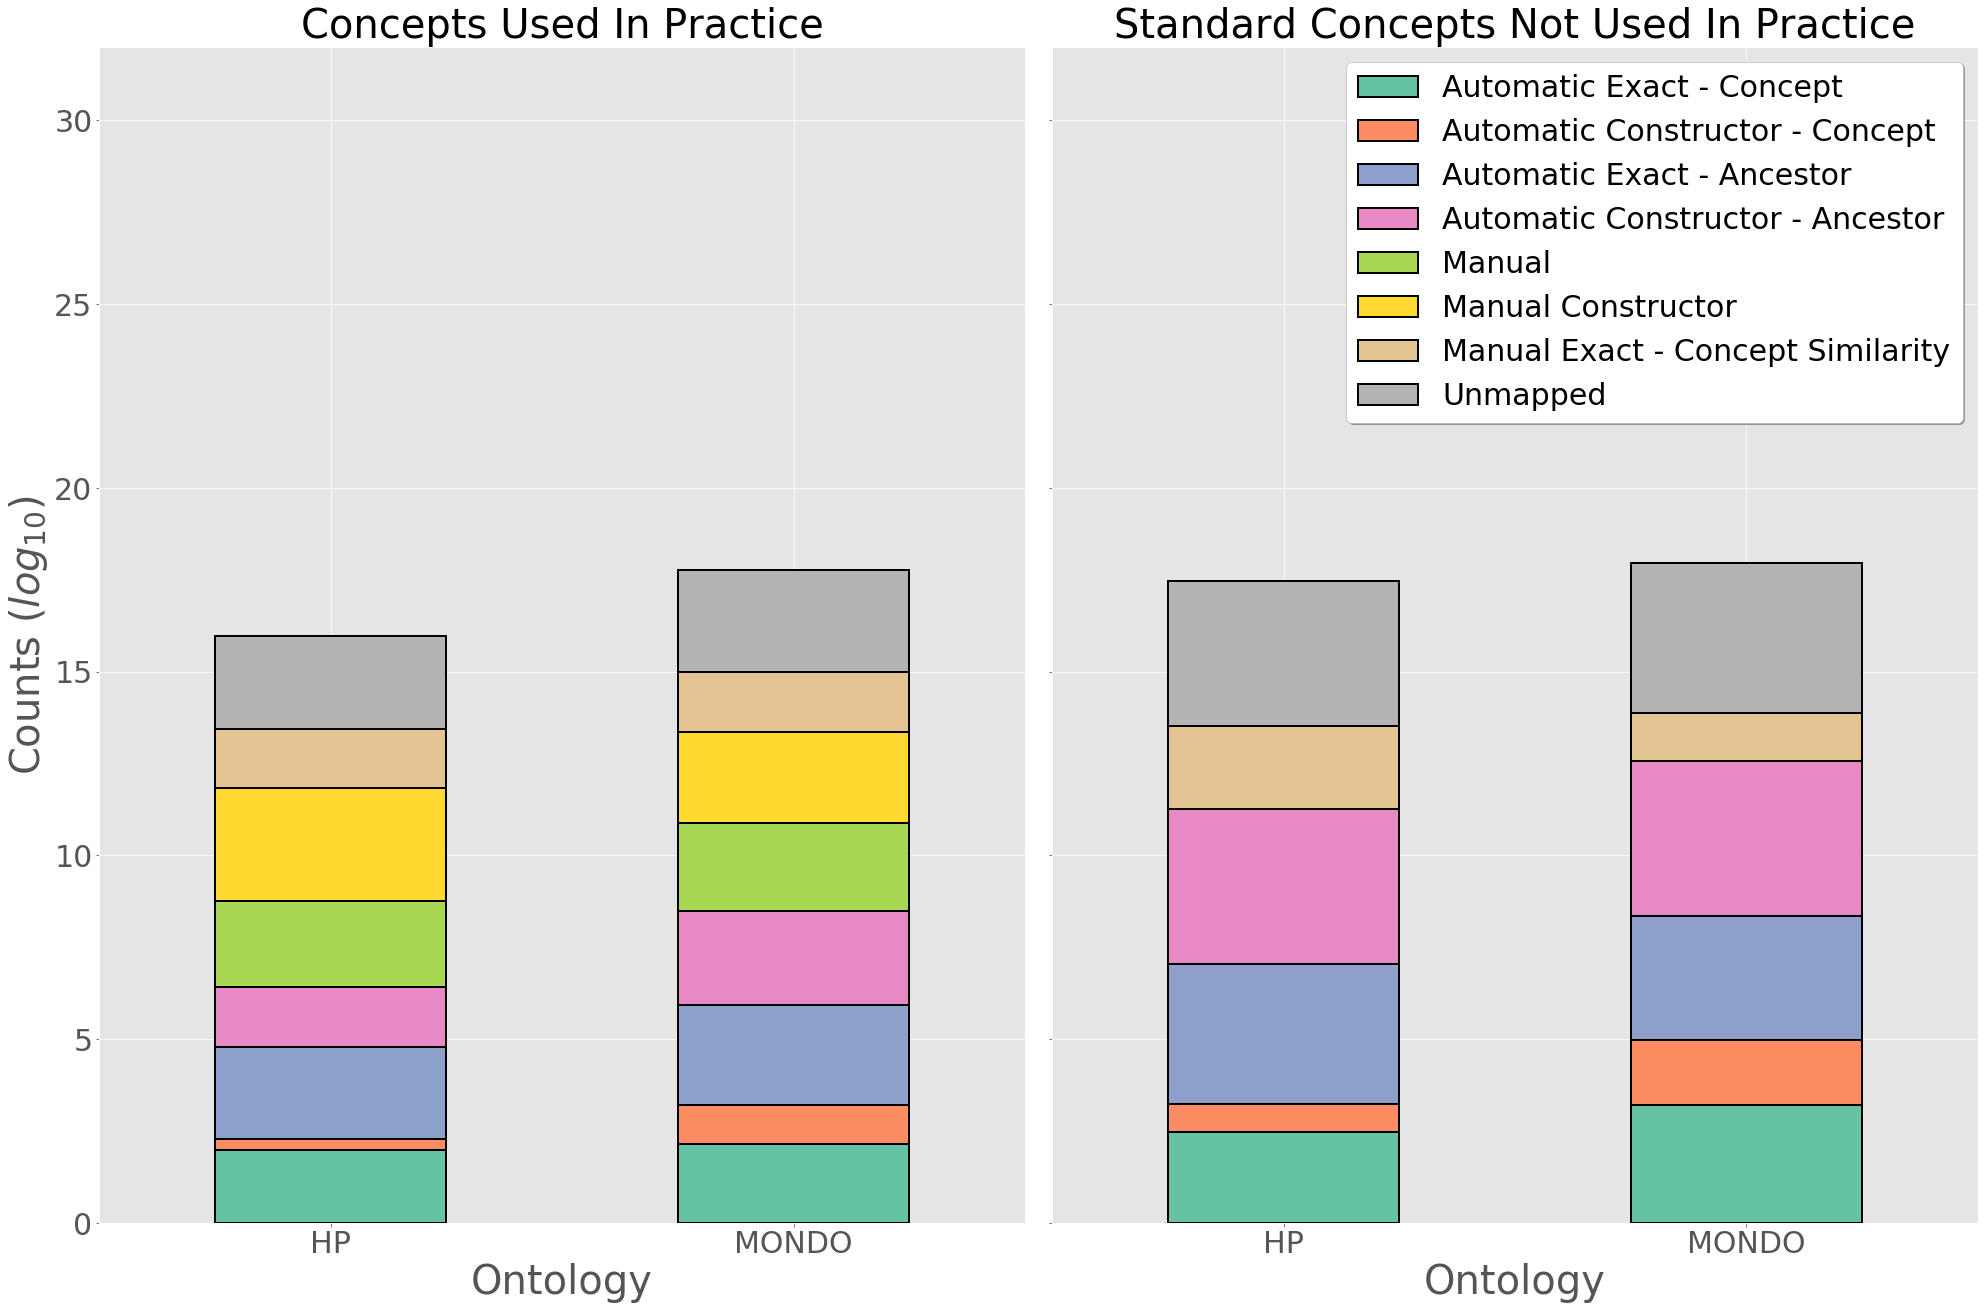

In [409]:
# create plot data
plots = { 'Concepts Used In Practice': prac_data, 'Standard Concepts Not Used In Practice': stnd_data}

ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Concept',
           'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
            'Manual', 'Manual Constructor', 'Manual Exact - Concept Similarity', 'Unmapped']

# create plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 18))

for df, ax in zip(plots.keys(), axes):
    plt_data = plots[df].pivot(index='ontology', columns='mapping_category', values='counts')
    plt_data = plt_data.reindex(ordering, axis=1)
    ax = plt_data.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', linewidth=2, colormap='Set2')
    ax.set_title(df, fontsize=40, alpha=1.0)
    ax.set_ylabel('Counts ($log_{10}$)', fontsize=40),
    ax.set_xlabel('Ontology', fontsize=40),
    ax.set_ylim(0, 32)
    ax.set_yticks(range(0, 32, 5))
    ax.set_yticklabels(labels=range(0, 32, 5), rotation=0, minor=False, fontsize=30)
    ax.set_xticklabels(labels=list(plt_data.index), rotation=0, minor=False, fontsize=30)
    handles, labels = ax.get_legend_handles_labels()

# look "one plot"
plt.tight_layout(pad=0.0, w_pad=-6.5, h_pad=0.0)
axes[1].set_ylabel("")
axes[1].set_yticklabels("")
axes[0].legend().set_visible(False)
axes[1].legend(ordering, fontsize=30, shadow=True, facecolor='white', edgecolor='darkgray', ncol=1)

**Error Analysis**


In [445]:
error_analysis


,relationship_id,SOURCE_CONCEPT_ID,SOURCE_CONCEPT_LABEL,TARGET_CONCEPT_ID,TARGET_CONCEPT_LABEL
0,Concept poss_eq from,134116,Dermatitis due to drug AND/OR medicine taken i...,4150178,Ingestion dermatitis due to drugs
1,Concept poss_eq from,42538028,CYP2C9 poor metabolizer,4310732,Disorder due cytochrome p450 CYP2C9 variant
2,Concept poss_eq from,443392,Malignant neoplastic disease,44801366,"[X]Malignant neoplasm of ill-defined, secondar..."
3,Concept poss_eq from,4108900,Embryonic cyst of ovary,4108899,Developmental ovarian cyst
4,Concept poss_eq from,42539465,Normal cellular hormonal pattern,4178575,Normal cellular hormonal pattern
...,...,...,...,...,...
34189,Maps to,36713411,Inflammatory disorder of skin of vulva,4298719,Inflammatory dermatosis of female genitalia
34190,Maps to,442610,Degenerative AND/OR vascular disorder of ear,42537214,Degenerative disorder of ear
34191,Maps to,4025935,Finding of appearance of skin,141960,Skin finding
34192,Maps to,4170123,Unclassified metabolic disorder,444377,Inborn error of metabolism


In [499]:
not_covered = concept_prev_conds[concept_prev_conds.CONCEPT_ID.isin(list(only_cp_cond_concepts))]
not_covered_concepts = only_cp_cond_concepts

# concepts in error analysis set
in_error_analysis = error_analysis[error_analysis.TARGET_CONCEPT_ID.isin(list(only_cp_cond_concepts))]

# concepts in excluded CHCO (and not found in error analysis)
in_excluded_chco = cond_mappings[~cond_mappings.CONCEPT_ID.isin(list(cond_mappings_standard['CONCEPT_ID']))]
excluded = in_excluded_chco[~in_excluded_chco.isin]

# remaining unexplained concepts
not_excluded = only_cp_cond_concepts.difference(set(list(in_excluded_chco['CONCEPT_ID']) + list(in_error_analysis['TARGET_CONCEPT_ID']) + list(cond_mappings_standard['CONCEPT_ID'])))
unexplained = cond_mappings_standard[cond_mappings_standard.CONCEPT_ID.isin(not_excluded)]


In [498]:
in_error_analysis.groupby('relationship_id').size().reset_index(name='COUNT')


,relationship_id,COUNT
0,Concept replaced by,31
1,Is a,1232
2,Maps to,198


In [500]:
in_excluded_chco


,CONCEPT_ID,CONCEPT_LABEL,CONCEPT_TYPE,STANDARD,CUI,SEMANTIC_TYPE,HP_LOGIC,HP_URI,HP_LABEL,HP_MAPPING,HP_EVIDENCE,MONDO_LOGIC,MONDO_URI,MONDO_LABEL,MONDO_MAPPING,MONDO_EVIDENCE,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
10861,9176,"Patient status determination, deceased",Standard Concept Not Used In Practice,S,C0184772,Finding,NOT YET MAPPED,NOT YET MAPPED,NOT YET MAPPED,Unmapped,"Concept could not be mapped using DbXRefs, exa...",FINDING,FINDING,FINDING,Unmapped,"Clinical finding, sign, or symptom without a c...",NaN,NaN,NaN
10864,72700,Locked twins with antenatal problem,Standard Concept Not Used In Practice,S,C0405183,Pathologic Function,NOT YET MAPPED,NOT YET MAPPED,NOT YET MAPPED,Unmapped,"Concept could not be mapped using DbXRefs, exa...",NOT YET MAPPED,NOT YET MAPPED,NOT YET MAPPED,Unmapped,"Concept could not be mapped using DbXRefs, exa...",NaN,NaN,NaN
10867,73282,"Breast engorgement in pregnancy, the puerperiu...",Standard Concept Not Used In Practice,S,C0405322,Disease or Syndrome,NOT YET MAPPED,NOT YET MAPPED,NOT YET MAPPED,Unmapped,"Concept could not be mapped using DbXRefs, exa...",NOT YET MAPPED,NOT YET MAPPED,NOT YET MAPPED,Unmapped,"Concept could not be mapped using DbXRefs, exa...",NaN,NaN,NaN
10872,75936,Mammography finding,Standard Concept Not Used In Practice,S,C1268642,Finding,NOT YET MAPPED,NOT YET MAPPED,NOT YET MAPPED,Unmapped,"Concept could not be mapped using DbXRefs, exa...",FINDING,FINDING,FINDING,Unmapped,"Clinical finding, sign, or symptom without a c...",NaN,NaN,NaN
10878,77056,Failure of lactation - delivered,Standard Concept Not Used In Practice,S,C0157655,Finding,NOT YET MAPPED,NOT YET MAPPED,NOT YET MAPPED,Unmapped,"Concept could not be mapped using DbXRefs, exa...",FINDING,FINDING,FINDING,Unmapped,"Clinical finding, sign, or symptom without a c...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85255,4282918,Normal variation in position,Concept Used In Practice,S,C0332446,Qualitative Concept,NONE,NONE,NONE,Unmapped,No applicable ontology term in current release,NONE,NONE,NONE,Unmapped,No matching ontology concept,Conditions,1.0,100.0
85256,4299535,Patient currently pregnant,Concept Used In Practice,S,C0032961 | C0549169 | C0549206,Organism Function | Finding,NONE,NONE,NONE,Unmapped,No applicable ontology term in current release,NONE,NONE,NONE,Unmapped,No matching ontology concept,Conditions,9879.0,9879.0
85257,4323130,Home environment related disease,Concept Used In Practice,S,C0277571,Disease or Syndrome,NONE,NONE,NONE,Unmapped,No applicable ontology term in current release,NONE,NONE,NONE,Unmapped,No matching ontology concept,Conditions,2.0,100.0
85258,4329455,Adolescence period,Concept Used In Practice,S,C0001578 | C0087178,Temporal Concept | Age Group,NONE,NONE,NONE,Unmapped,No applicable ontology term in current release,NONE,NONE,NONE,Unmapped,No matching ontology concept,Conditions,3682.0,3682.0


<br>

#### Database Coverage<a class="anchor" id="cond-database-coverage"></a>  



In [431]:
# Get concept coverage by database
conds_coverage_dict = gets_group_stats(concept_prev_conds.copy(), cond_mappings_standard.copy(), 'DATABASE_NAME', 'CONCEPT_ID')

# create contingency table
dbs = list(conds_coverage_dict.keys())
db_covered = [len(conds_coverage_dict[j]['overlap'].keys()) for j in dbs]
db_not_covered = [len(conds_coverage_dict[j]['primary_only'].keys()) for j in dbs]

# convert to Pandas DataFrame
conds_coverage_df = pd.DataFrame({'Database': dbs, 'Covered': db_covered, 'Not Covered': db_not_covered})

# calculate coverage 
conds_coverage_df['% Coverage'] = round(conds_coverage_df['Covered']/(conds_coverage_df['Covered'] + conds_coverage_df['Not Covered'])*100, 3)

# view table
conds_coverage_df


  8%|▊         | 2/24 [00:00<00:01, 13.96it/s]

Processing 24 Database groups



100%|██████████| 24/24 [00:01<00:00, 17.11it/s]


,Database,Covered,Not Covered,% Coverage
0,Ajou_university,6023,32,99.472
1,AmbEMR,46365,2170,95.529
2,Australia_JJ,3453,83,97.653
3,DA_France,3341,30,99.110
4,DA_Germany,6555,88,98.675
5,HCUP,9268,53,99.431
6,Hospital,15556,150,99.045
7,IBM_CCAE,15698,161,98.985
8,IBM_MDCD,15484,152,99.028
9,IBM_MDCR,15102,136,99.107


*Chi-Square Test*  
A Chi-Square test of independence was run to determine if coverage available differed by database. First, an omnibus test was run to determine whether there was a significant relationship between database and coverage. Results from this test (with Yate's correction) revealed a significant association between the database and coverage ($X^{2}(23)=7,559.11$, $p<0.0001$). In order to better understand these findings, post-hoc tests were run using a Bonferroni adjustment to correct for multiple comparisons. These tests confirmed that `107` of the `276` database comparisons had significantly different coverage ($ps<0.001$).


In [426]:
# reformat data to create contingency table
dbs = list(conds_coverage_dict.keys())
db_names = [[j] * (len(conds_coverage_dict[j]['overlap'].keys()) + len(conds_coverage_dict[j]['primary_only'].keys())) for j in dbs]
res = [['Yes'] * len(conds_coverage_dict[j]['overlap'].keys()) + ['No'] * len(conds_coverage_dict[j]['primary_only'].keys()) for j in dbs]

# create df
df = pd.DataFrame({'database': [x for y in db_names for x in y], 'coverage': [x for y in res for x in y]})

# create cross-tab view
df_cross = pd.crosstab(df['database'], df['coverage'])

# perform post hoc analysis adjusting applying multiple comparisons correction
# other correction types available: https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
result = chisq_and_posthoc_corrected(df_cross, 'bonferroni')

# group results by outcome
chi_res = result.groupby('reject_h0')
chi_diff = chi_res.get_group(True).drop_duplicates()
chi_same = chi_res.get_group(False).drop_duplicates()


Chi-Square Omnibus Test Results: Test statistic: 7559.105383635358, df: 23, p-value: 0.0
Performing post hoc testing using: bonferroni p-value correction method


In [424]:
chi_diff

,comparison,original_pvalue,corrected_pvalue,reject_h0
0,Ajou_university-AmbEMR,1.036396e-48,2.860454e-46,True
1,Ajou_university-Australia_JJ,6.286822e-15,1.735163e-12,True
3,Ajou_university-DA_Germany,5.628698e-06,1.553521e-03,True
14,Ajou_university-OPTUM_PANTHER,1.464492e-84,4.041999e-82,True
19,Ajou_university-Tufts,9.353125e-07,2.581462e-04,True
...,...,...,...,...
265,Pscanner-ohdsi_cumc_deid_2018q4,2.221539e-07,6.131448e-05,True
266,Stanford-Tufts,1.252688e-14,3.457420e-12,True
267,Stanford-UCHealth,2.448216e-17,6.757077e-15,True
268,Stanford-ePBRN_OMOP_CDM53_V3a_NOV_2017,1.243824e-09,3.432955e-07,True


In [425]:
chi_same

,comparison,original_pvalue,corrected_pvalue,reject_h0
2,Ajou_university-DA_France,0.051431,1.000000,False
4,Ajou_university-HCUP,0.828585,1.000000,False
5,Ajou_university-Hospital,0.002584,0.713114,False
6,Ajou_university-IBM_CCAE,0.000759,0.209385,False
7,Ajou_university-IBM_MDCD,0.001850,0.510672,False
...,...,...,...,...
271,Tufts-ePBRN_OMOP_CDM53_V3a_NOV_2017,0.956565,1.000000,False
272,Tufts-ohdsi_cumc_deid_2018q4,0.426464,1.000000,False
273,UCHealth-ePBRN_OMOP_CDM53_V3a_NOV_2017,0.555180,1.000000,False
274,UCHealth-ohdsi_cumc_deid_2018q4,0.041092,1.000000,False


*Database Coverage Results - Concept Frequency*

In [432]:
# get range of concept frequency for codes not covered by OMOP2OBO
omop2obo_not_covered, cp_not_covered, omop2obo_not_plt, cp_not_plt = [], [], [], []

for grp in conds_coverage_dict.keys():
    
    # cp not in omop2obo
    cp_not = conds_coverage_dict[grp]['primary_only'].values()    
    cp_not_covered.append([grp, min(cp_not), max(cp_not), statistics.median(cp_not)])
    cp_not_plt.append([[grp] * len(cp_not), cp_not])
    
    # omop2obo not in cp
    omop2obo_not = conds_coverage_dict[grp]['secondary_only'].values()    
    omop2obo_not_covered.append([grp, min(omop2obo_not), max(omop2obo_not), statistics.median(omop2obo_not)])
    omop2obo_not_plt.append([[grp] * len(omop2obo_not), omop2obo_not])

    
# create pandas dfs
cond_cp_not_covered = pd.DataFrame({'database': [x[0] for x in cp_not_covered],
                                   'min_freq': [x[1] for x in cp_not_covered],
                                   'max_freq': [x[2] for x in cp_not_covered],
                                   'median_freq': [x[3] for x in cp_not_covered]})
    
cond_omop2obo_not_covered = pd.DataFrame({'database': [x[0] for x in omop2obo_not_covered],
                                          'min_freq': [x[1] for x in omop2obo_not_covered],
                                          'max_freq': [x[2] for x in omop2obo_not_covered],
                                          'median_freq': [x[3] for x in omop2obo_not_covered]})    
    

In [433]:
# concepts not covered by OMOP2OBO
cond_cp_not_covered


,database,min_freq,max_freq,median_freq
0,Ajou_university,100,55534,195.5
1,AmbEMR,100,16508273,100.0
2,Australia_JJ,100,37866,100.0
3,DA_France,100,34425,137.5
4,DA_Germany,100,337355,541.5
5,HCUP,100,279438,264.0
6,Hospital,100,2312481,248.5
7,IBM_CCAE,100,6133301,839.0
8,IBM_MDCD,100,52739431,509.5
9,IBM_MDCR,100,390160,100.0


In [434]:
{k: v for k, v in sorted(conds_coverage_dict['OpenClaims']['primary_only'].items(), key=lambda item: item[1], reverse=True)}


{4299535: 11663870,
 42537748: 9837914,
 40277917: 7337686,
 195321: 7311087,
 42538119: 7242961,
 42539502: 6338237,
 4094448: 4883853,
 42537730: 4704662,
 4211799: 4040102,
 4094910: 3721757,
 37109843: 3616353,
 35624756: 2671622,
 44783356: 2106046,
 35624757: 1988250,
 35622934: 1636057,
 42538117: 1218131,
 40400785: 1135141,
 4084768: 932448,
 45757639: 886129,
 35624485: 657149,
 42537744: 570192,
 35623051: 497553,
 35622759: 385028,
 4164707: 341004,
 40548161: 339860,
 4081173: 298473,
 35625971: 295804,
 35622958: 248933,
 4088588: 236284,
 444125: 167642,
 4064437: 150629,
 77615: 120863,
 35615055: 116686,
 45763587: 110434,
 42537741: 105844,
 4063163: 100009,
 4122735: 92451,
 4028644: 88611,
 35624169: 79602,
 35610112: 76480,
 45757381: 76331,
 195591: 74431,
 81086: 62589,
 35624320: 50374,
 45763588: 48222,
 35623263: 43790,
 40599994: 42645,
 4166130: 41540,
 199087: 35735,
 4090861: 33620,
 35626038: 30040,
 44784551: 29371,
 35625873: 29333,
 35626039: 28330,
 3

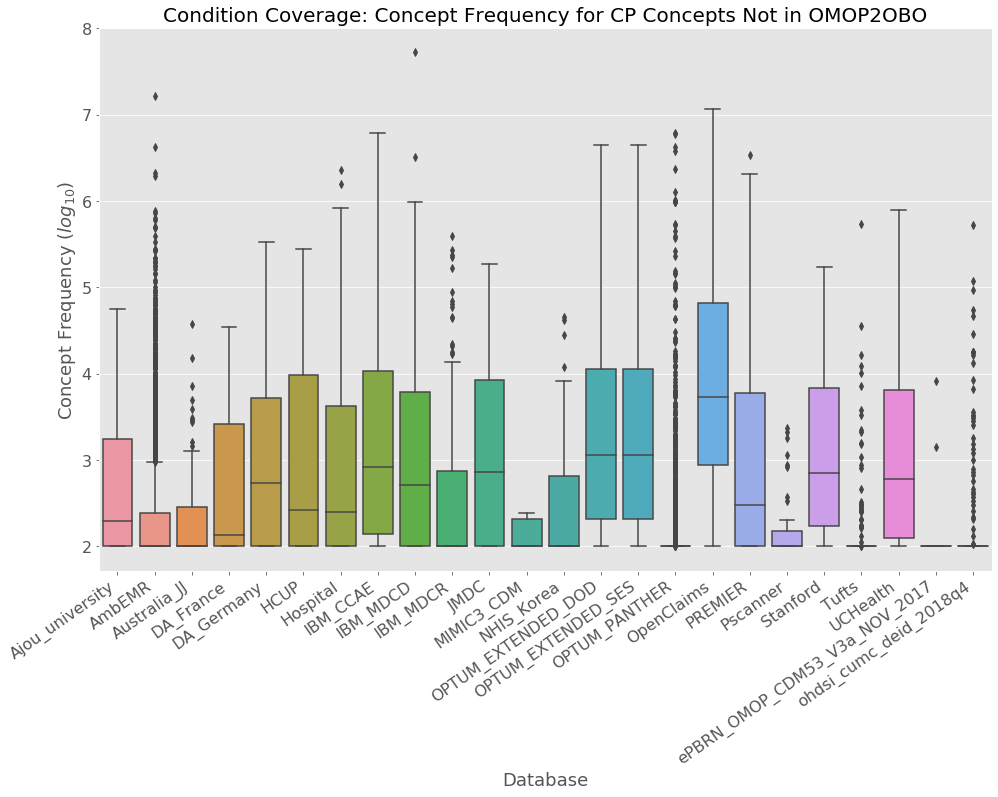

In [438]:
# create plot data
omop_not_cond_plot = pd.DataFrame({'database': [x for y in cp_not_plt for x in y[0]],
                                   'concept_frequency': [math.log10(x) for y in cp_not_plt for x in y[1]]})

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sboxplot = sns.boxplot(y='concept_frequency', x='database', data=omop_not_cond_plot)

sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=35, horizontalalignment='right')

plt.title('Condition Coverage: Concept Frequency for CP Concepts Not in OMOP2OBO', fontsize=20)
plt.suptitle("")
plt.xlabel('Database', fontsize=18)
plt.ylabel('Concept Frequency ($log_{10}$)', fontsize=18)
plt.tick_params(labelsize=16)
plt.show()



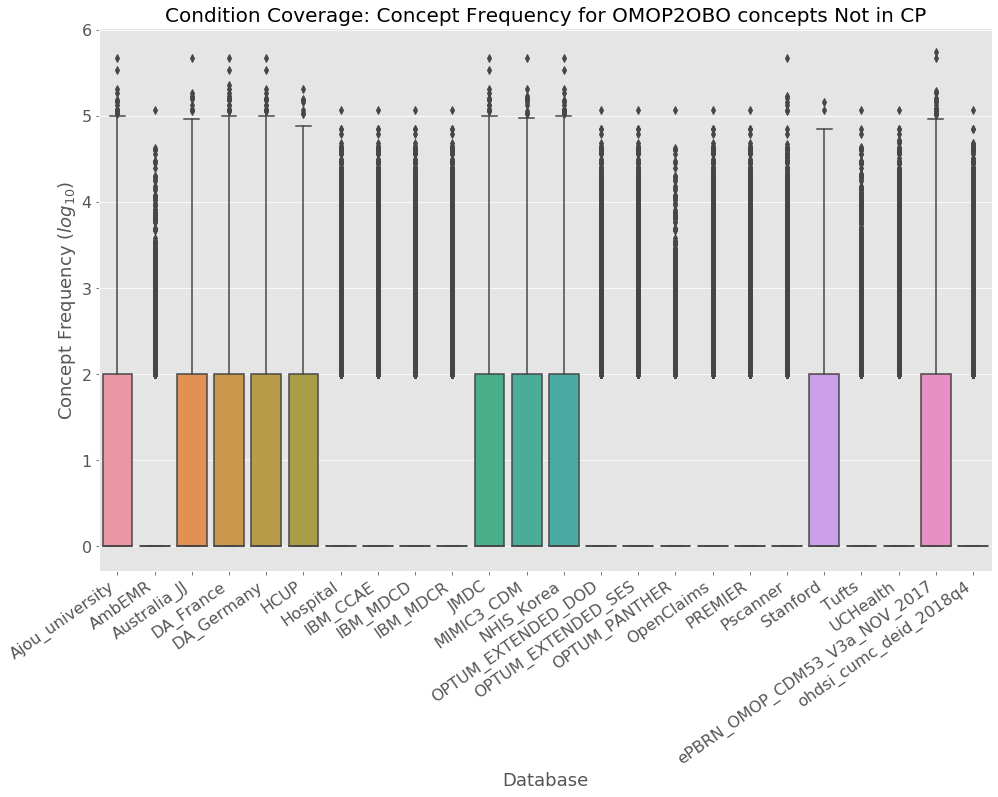

In [440]:
# create plot data
cp_not_cond_plot = pd.DataFrame({'database': [x for y in omop2obo_not_plt for x in y[0]],
                                 'concept_frequency': [math.log10(x) if x > 1 else 0 for y in omop2obo_not_plt for x in y[1]]})

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sboxplot = sns.boxplot(y='concept_frequency', x='database', data=cp_not_cond_plot)

sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=35, horizontalalignment='right')

plt.title('Condition Coverage: Concept Frequency for OMOP2OBO concepts Not in CP', fontsize=20)
plt.suptitle("")
plt.xlabel('Database', fontsize=18)
plt.ylabel('Concept Frequency ($log_{10}$)', fontsize=18)
plt.tick_params(labelsize=16)
plt.show()



### Drug Ingredients <a class="anchor" id="coverage-drugs"></a>



### Measurements <a class="anchor" id="coverage-labs"></a>



***

**Click [here](#mapping-validation) to return to the Mapping Validation section**  

***

<br>

## Logical Validation <a class="anchor" id="logical-eval"></a>

***
    

***

**Click [here](#mapping-validation) to return to the Mapping Validation section**  

***

***

<br>

This project is licensed under MIT - see the **[`LICENSE.md`](https://github.com/callahantiff/OMOP2OBO/blob/master/LICENSE)** file for details. If you intend to use any of the information on this Wiki, please provide the appropriate attribution by citing this repository:  

```
@misc{callahan_tj_2020_4247939,
  author       = {Callahan, TJ},
  title        = {OMOP2OBO},
  month        = jun,
  year         = 2021,
  doi          = {10.5281/zenodo.4247939},
  url          = {https://doi.org/10.5281/zenodo.4247939}
}
```